# Read me
This template is meant to be a starter for your customized DREEM output data analysis.

- To install this library, please check the installation on the [Git repo](https://github.com/yvesmartindestaillades/NAP).
- To learn how to use this library, please get through the [tutorial](tutorial.ipynb).


# Turner overthrown

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import exists, dirname
import os, sys
import string
import numpy as np
import seaborn as sns
sys.path.append(os.path.abspath(".."))

from NAP import data_wrangler, utils, database, plot #TODO, import * doesn't wosl


# Step 1: Data wrangling
### Step 1.1: Define your study and some basics about your project

In [2]:
# Set your root folder for the database (at the moment, keep Yves)
folder = 'Yves'

# Select your study
study_name = 'all_samples' 

## Set your base coverage high-pass filter value
min_bases_cov = 1000 

# Set the resolution for the plots
mpl.rcParams['figure.dpi'] = 200 # the highest the resolution, the slowest the plotting
plt.rcParams["figure.figsize"] = [25, 7]
#plt.rcParams["figure.autolayout"] = True


# Depending on the study you select, you'll get a series of samples. You can also create new studies using this dictionary.
# Here's an example.
studies = {
    'temperature': {
        'name': 'temperature',
        'samples': ['D7', 'E7', 'F7', 'G7', 'H7', 'A8', 'B8', 'C8'], 
        'unit':'deg C',
        'values':[5, 10, 25, 45, 55, 65, 75, 90]
    },
    '60 mM DMS kinestics': {
        'name':'60 mM DMS kinestics',
        'samples':['D8', 'E8', 'F8', 'G8', 'H8', 'A9'],
        'unit':'min',
        'values':[1, 3, 9, 27, 81]
    },
    'PEG8K':  {
        'name':'PEG8K',
        'samples': ['A1','B1','C1','D1'],
        'unit': '[%]',
        'values': [2.5, 5, 10, 20]
    },
    'PEG 3350':  {
        'name':'PEG 3350',
        'samples': ['E1','F1','G1','H1'],
        'unit': '[%]',
        'values': [2.5, 5, 10, 20]
    }, 
    'PEG 1K':  {
        'name':'PEG 1K',
        'samples': ['A2','B2','C2','D2'],
        'unit': '[%]',
        'values': [2.5, 5, 10, 20]
    }, 
    'spermine': {
        'name':'spermine',
        'samples': ['E2','F2','G2','H2','A3'],
        'unit': '[mM]',
        'values': [0.01, 0.1, 1, 10, 100]
    },        
    'spermidine': {
        'name':'spermidine',
        'samples': ['B3','D3','E3','F3'], #C3 missing
        'unit': '[mM]',
        'values': [0.01, 1, 10, 100]
    },      
    'replicates':{
        'name':'replicates',
        'samples':['C5', 'A4', 'F4', 'A6', 'A7']
    },
    'salt':{
        'name':'salt',
        'samples':['A6', 'B6', 'C6', 'D6', 'E6'],
        'unit':'[M]',
        'values':[0.150, 0.300, 0.600, 1, 1.2]
    },
    'magnesium':{
        'name':'magnesium',
        'samples':['F6', 'G6', 'H6', 'A7', 'B7', 'C7'], 
        'unit':'mM',
        'values':[0, 0.01, 0.1, 1, 10, 100]
    },
    'all_samples':{
        'name': 'all_samples',
        'samples': [ele for ele in [f"{a}{b}" for a in string.ascii_uppercase[0:8] for b in range(1,11)] \
                 if ele not in ['C3','C10','D10','E10','F10','G10','H10', 'E4']]
                 + ['C5_realignment_v3']
    }
} 

# Define what you will analyse
study = studies[study_name]
samples = study['samples']

### Step 1.2: Process new pickle files and push them to Firebase
- Select which samples you want to push to Firebase.
To plot automatically arrays of samples, see [tutorial](tutorial.ipynb), section 3.2.
- Process samples and push them to Firebase.

In [3]:
## Pickle files to process and to push to Firebase
pickles_list = [] # Can be samples if you want to process the samples from your study

pickles = {pickle: f"../data/FULLSET/{pickle}/mutation_histos.p" for pickle in pickles_list}

# Indicate the location of your RNA structure file
RNAstructureFile = '../data/RNAstructureFile.csv'

# Default location for your local database (JSON file)
json_file = '../data/db.json'

# If the user gives some new pickles files, push them to the firebase, then pull the entire firebase
if len(pickles):
    data_wrangler.push_samples_to_firebase(pickles = pickles,
                        RNAstructureFile = RNAstructureFile,
                        min_bases_cov = min_bases_cov, 
                        folder=folder)

### Step 1.3: Pull the data from the Firebase and clean/reformat it.
`df` is used for the analysis. Each of the construct have above 1000 reads for each sample.     
`df_full` is used for quality quality analysis. It has all constructs above 1000 valid reads for each sample individually.

In [4]:
# Pull the firebase
#df_database = database.load(samples=samples, username=username)

#data_wrangler.dump_dict_json(JSONFileDict=json_file, df=df_database)
df_database = data_wrangler.json_load(json_file)

# Clean and reformat the dataset
df, df_full = data_wrangler.clean_dataset(df_database=df_database,
                                             samples=samples)
print(f"{df.groupby('construct')['samples_covered'].count().count()} constructs have more than {min_bases_cov} reads for each base of their ROI on each sample")
        

Load from dict-type JSON file
Done!


/home/ymdt/NAP/nap/data_wrangler.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['tubes_covered'].loc[construct[1].index] = construct[1]['full_sequence'].count()


0 constructs were dropped because deltaG was 'void'
61 constructs have more than 1000 reads for each base of their ROI on each tube


# Step 2: Data quality analysis

It's always hard to realize that you were analysing noise. Here, we'll get through a series a plot to check the data sanity.

ValueError: x and y must have same first dimension, but have shapes (5,) and (6,)

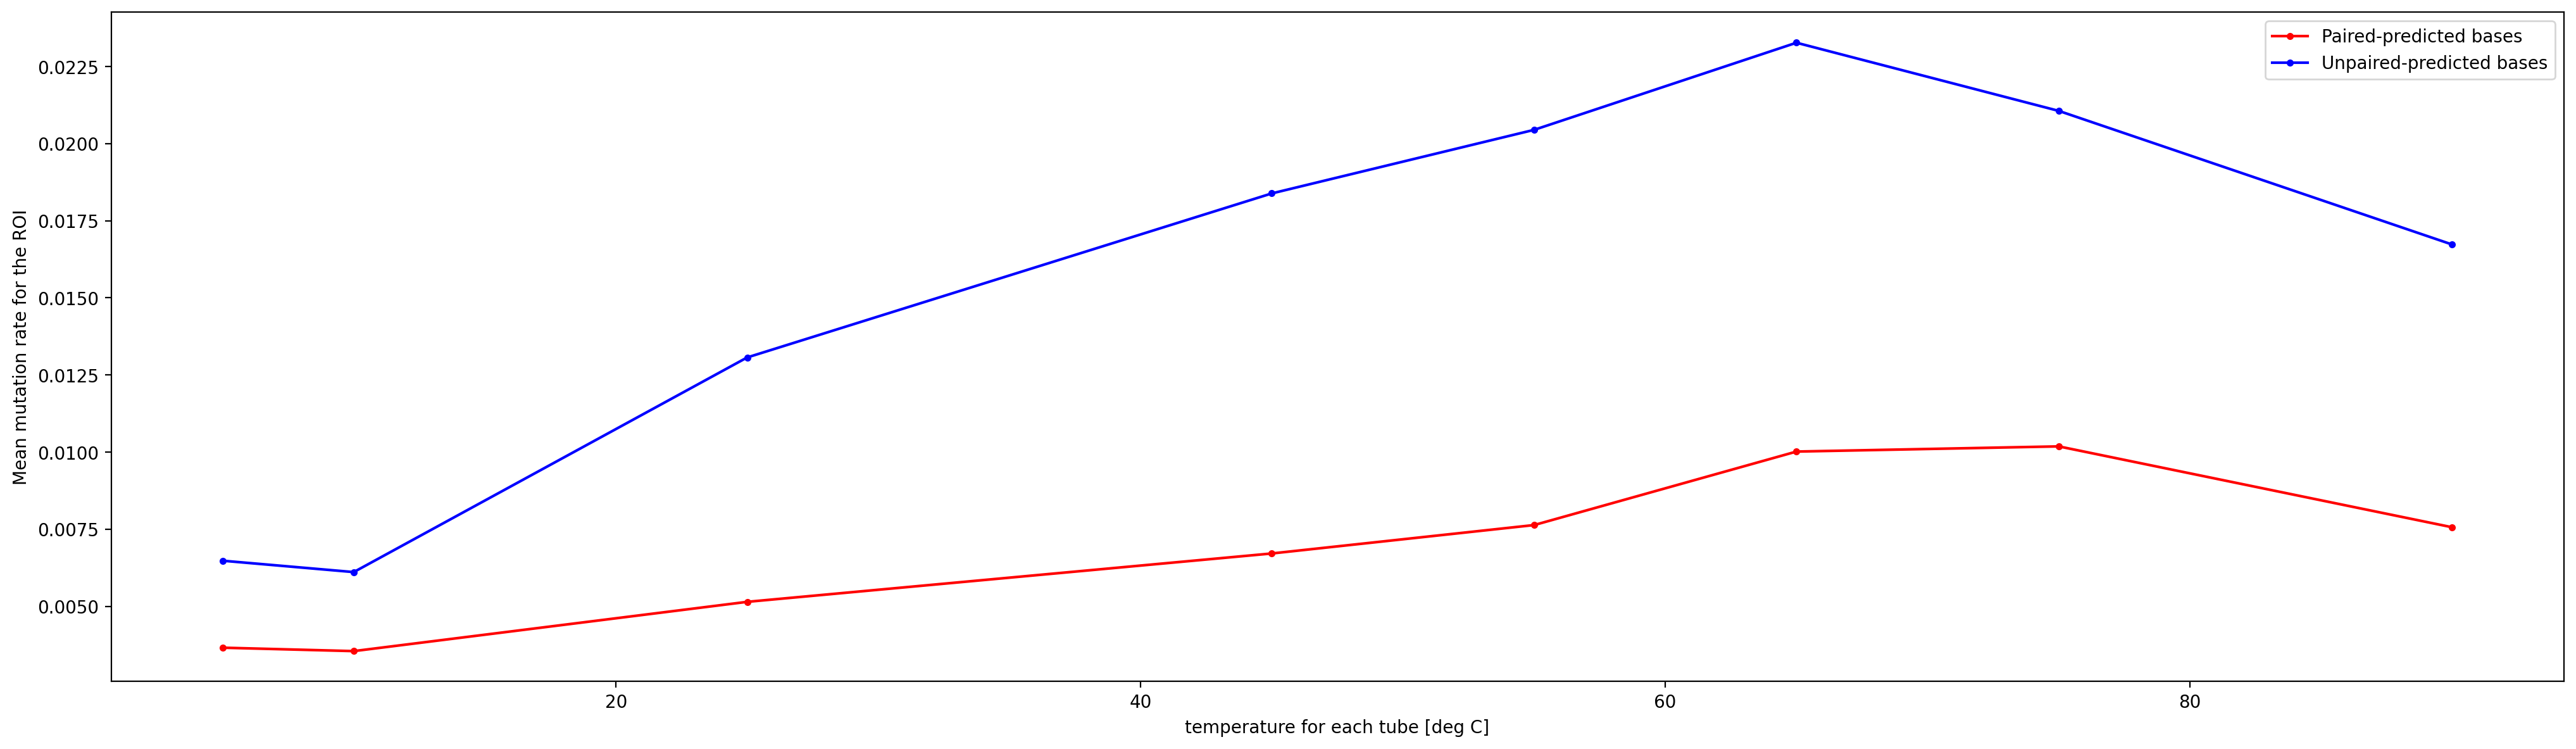

In [5]:
for study in studies:
    samples = studies[study]['samples']
    plot.mut_rate_along_study(df, samples, studies[study])
    utils.save_fig(path=f"data/figs/date/mut_bases_study-wise/",
                   title=f"mut_bases_along_{study}")

### Get the list of samples and constructs:

In [19]:
print(f"samples are: {samples}")
print(f"constructs are: {df.construct.unique()}")

tubes are: ['D7', 'E7', 'F7', 'G7', 'H7', 'A8', 'B8', 'C8']
constructs are: [  167   185   286   322   373   381   597   980  1009  1055  1063  1092
  1120  1495  1895  1994  2069  2093  2228  2323  2506  2524  2570  2780
  2797  3014  3163  3273  3337  3580  3708  3796  3925  3948  4274  4362
  4493  4585  4672  4708  4727  4758  5014  5269  5435  5440  5988  6317
  6458  6711  6896  7026  7172  7384  7487  7545  7808  7845  8106  8136
  8240  8280  8281  8351  8369  8422  8427  8430  8438  8574  8594  8695
  8758  9176  9211  9237  9302  9332  9572  9629  9796  9832  9843  9849
 10044 10162 10190 10663 10759 10803 10948 10992 11024 11035 11047 11197
 11217 11390 11499 11642 11659 11775 11825 12079 12108 12306 12361 12419]


### Explore the data
`get_roi_info(df=df, sample=sample, construct=construct)` gives information about the Region of Interest (ROI) of a (sample, construct) pair.

In [ ]:
sample, construct = utils.rand_sample_construct(df)
#utils.get_roi_info(df=df, sample=sample, construct=construct)#.xs((True, '0'),level=('paired','roi_structure_comparison'))   

utils.columns_to_csv(df, samples= ['E1','E7'], columns=['sample','construct','full_sequence'],title='test.csv',path='')

### (sample, construct)-specific base coverage plot

In [ ]:
sample, construct = utils.rand_sample_construct(df)
plot.base_coverage(df, sample, construct)

### Plot the base coverage per construct distribution

In [ ]:
plot.base_coverage_ROI_for_all_constructs(df=df_full)

### Sanity-check construct-wise base coverage plots
Plot randomly picked sequences to check the quality of the data.

In [ ]:
plot.random_9_base_coverage(df=df)

### Heatmap of the roi part coverage

In [ ]:
plot.heatmap(df = df, 
             column="cov_bases_roi")

### Heatmap of the second half coverage

In [ ]:
plot.heatmap(df = df, 
                column="cov_bases_sec_half")

# Step 3: Data analysis
In this part, we know that we read good data, and we want to visualize it through different plots.

### Analysis parameters

In [ ]:
# Display the plots on this notebook? Not recommended if numerous plots
show_plots = True

# Constructs used
a_few_constructs = df.construct.unique()[:3].tolist()
first_construct = df.construct.unique()[0].tolist()
constructs_per_name = {
    'all_constructs': df.construct.unique().tolist(),
    str(a_few_constructs) : a_few_constructs,
    str(first_construct): [first_construct]
}

# Select constructs here
constructs_name = str(a_few_constructs)

# Define what you will analyse
constructs = constructs_per_name[constructs_name]

### Big script to run every selected function

In [ ]:
# Analysis run in this script
analysis = {'base_per_base_partition':False,
            'base_per_base_sequence': True,
            'deltaG': True,
            'sample_comparison':False,
            'columns_csv': True,
            'deltaG_construct': True
            }

# Write here a script to get your plots 

### Mutation sequence-wise

`plot.mutation_rate(df, sample, construct, plot_type, index, normalize)` plots the mutation rate base-wise for a given construct of a given sample as a barplot. 
Arguments:
- `plot_type` :
    - `'sequence'` : each bar is colored w.r.t to the base of the original sequence.
    - `'partition'` : each bar shows the partition of into which bases this base mutates.
- `index`:
    - `'index'`: each base is identified with its position number
    - `'base'`: each base is identified with its type (A, C, G, T)

In [ ]:
for construct in constructs:
    for sample in samples:
        plot.mutation_rate(df=df,
                           sample=sample,
                           construct=construct,
                           plot_type='sequence',
                           index='index')
        utils.save_fig(path=f"data/figs/date/{study}/mut_per_base/sequence/{construct}/", 
                    title=f"base_per_base_sequence_{sample}_{construct}")
        plt.close(not show_plots)

### DeltaG plots

In [ ]:
for sample in samples:
    plot.deltaG(df=df, sample=sample)

    utils.save_fig(path=f"data/figs/date/{study}/deltaG/", 
             title=f"deltaG_{sample}")

    plt.close(not show_plots)

### samples correlation

In [ ]:
for construct in [constructs[0]]:
        df_global_corr = plot.correlation_n_samples(df, samples, construct)
        utils.save_fig(path=f"data/figs/date/correlation/{study}", 
                      title=f"correlation_{study}_{construct}")
        plt.title(f"Study: {study}")
        plt.close(not show_plots)
        print(construct, end=' ')

In [ ]:
show_plots = False
for study in studies:
    samples = study['samples']
    for constructs in df.construct.unique():
        constructs_name = constructs
        df_global_corr = plot.correlation_n_samples(df, samples, constructs)
        plt.title(f"Correlation between samples for study: {study}, constructs: {constructs_name}")
        utils.save_fig(path=f"data/figs/date/correlation/{study}/{constructs_name}", 
                        title=f"correlation_fit_{study}_{constructs_name}")
        plt.close(not show_plots)

        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
            plt.title(f"{plt_type} of the correlation between samples for study: {study}, constructs: {constructs_name}")
            utils.save_fig(path=f"data/figs/date/correlation/{study}/{constructs_name}", 
                            title=f"correlation_{plt_type}_{study}_{constructs_name}")
            plt.close(not show_plots)

### Heat Map

In [ ]:
#pivot = df_global_corr.pivot("sample_0","sample_1", 'r_value').astype(float)
df_global_corr

In [ ]:
for plt_type in ['r_value', 'slope']:
    pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
    f, ax = plt.subplots(figsize=(28, 10))
    sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
    plt.title(plt_type)
    utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                    title=f"correlation_{plt_type}_{study}_all_constructs")
   # plt.close(not show_plots)

### Global correlation plot

In [ ]:
heat_map = True

for study in studies:
    samples = study['samples']
    df_global_corr = plot.correlation_n_samples(df, samples, constructs)
    utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                    title=f"correlation_{study}_all_constructs")
    plt.close(not show_plots)

    if heat_map:
        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("sample_0","sample_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax, norm=LogNorm())
            utils.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                            title=f"correlation_{plt_type}_{study}_all_constructs")
            plt.close(not show_plots)

In [7]:
show_plots = 1
for study in studies:
    samples = studies[study]['samples']
    if study == 'all_samples': continue
    plot.correlation_n_samples(df, samples, constructs)
    plot.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                title=f"correlation_{study}_all_constructs")
    plt.close(not show_plots)

NameError: name 'df' is not defined

 ### Conditions vs mutations #TODO

In [ ]:
def conditions_vs_mutations(df, samples, study, ):
    df_use = df.set_index(['sample','construct'])

    fig = plot.define_figure(title=sample,
                            xlabel='deltaG [kcal]',
                            ylabel='Mutation ratio',
                            figsize=(20,5))

    stack_for_plot = {'0':{'x':[],'y':[]},'1':{'x':[],'y':[]}}

    for construct in df.construct.unique():
        roi_part = utils.get_roi_info(df=df, sample=sample, construct=construct)
        for base in ['A','C']:
            for roi_struct_comp in ['0','1']:
                try:    
                    this_base_mut =  roi_part.xs((base,True,roi_struct_comp), level=('base','paired','roi_structure_comparison'))
                    stack_for_plot[roi_struct_comp]['x'].extend(this_base_mut['roi_deltaG'].to_list())
                    stack_for_plot[roi_struct_comp]['y'].extend(this_base_mut['mut_rate'].to_list())
                except:
                    continue
    plt.plot(stack_for_plot['0']['x'],stack_for_plot['0']['y'],'b.')
    plt.plot(stack_for_plot['1']['x'],stack_for_plot['1']['y'],'r.')
    plot.fit_deltaG(df_use, sample)
    plt.legend(['A and C bases of the ROI, predicted paired by RNAstructure for both the ROI sequence and the full sequence',\
                'A and C bases of the ROI part, predicted paired by RNAstructure for the full sequence but not for the ROI sequence'])
    plt.ylim([0,0.15])
    fig.tight_layout()

### Temperature vs reactivity plots

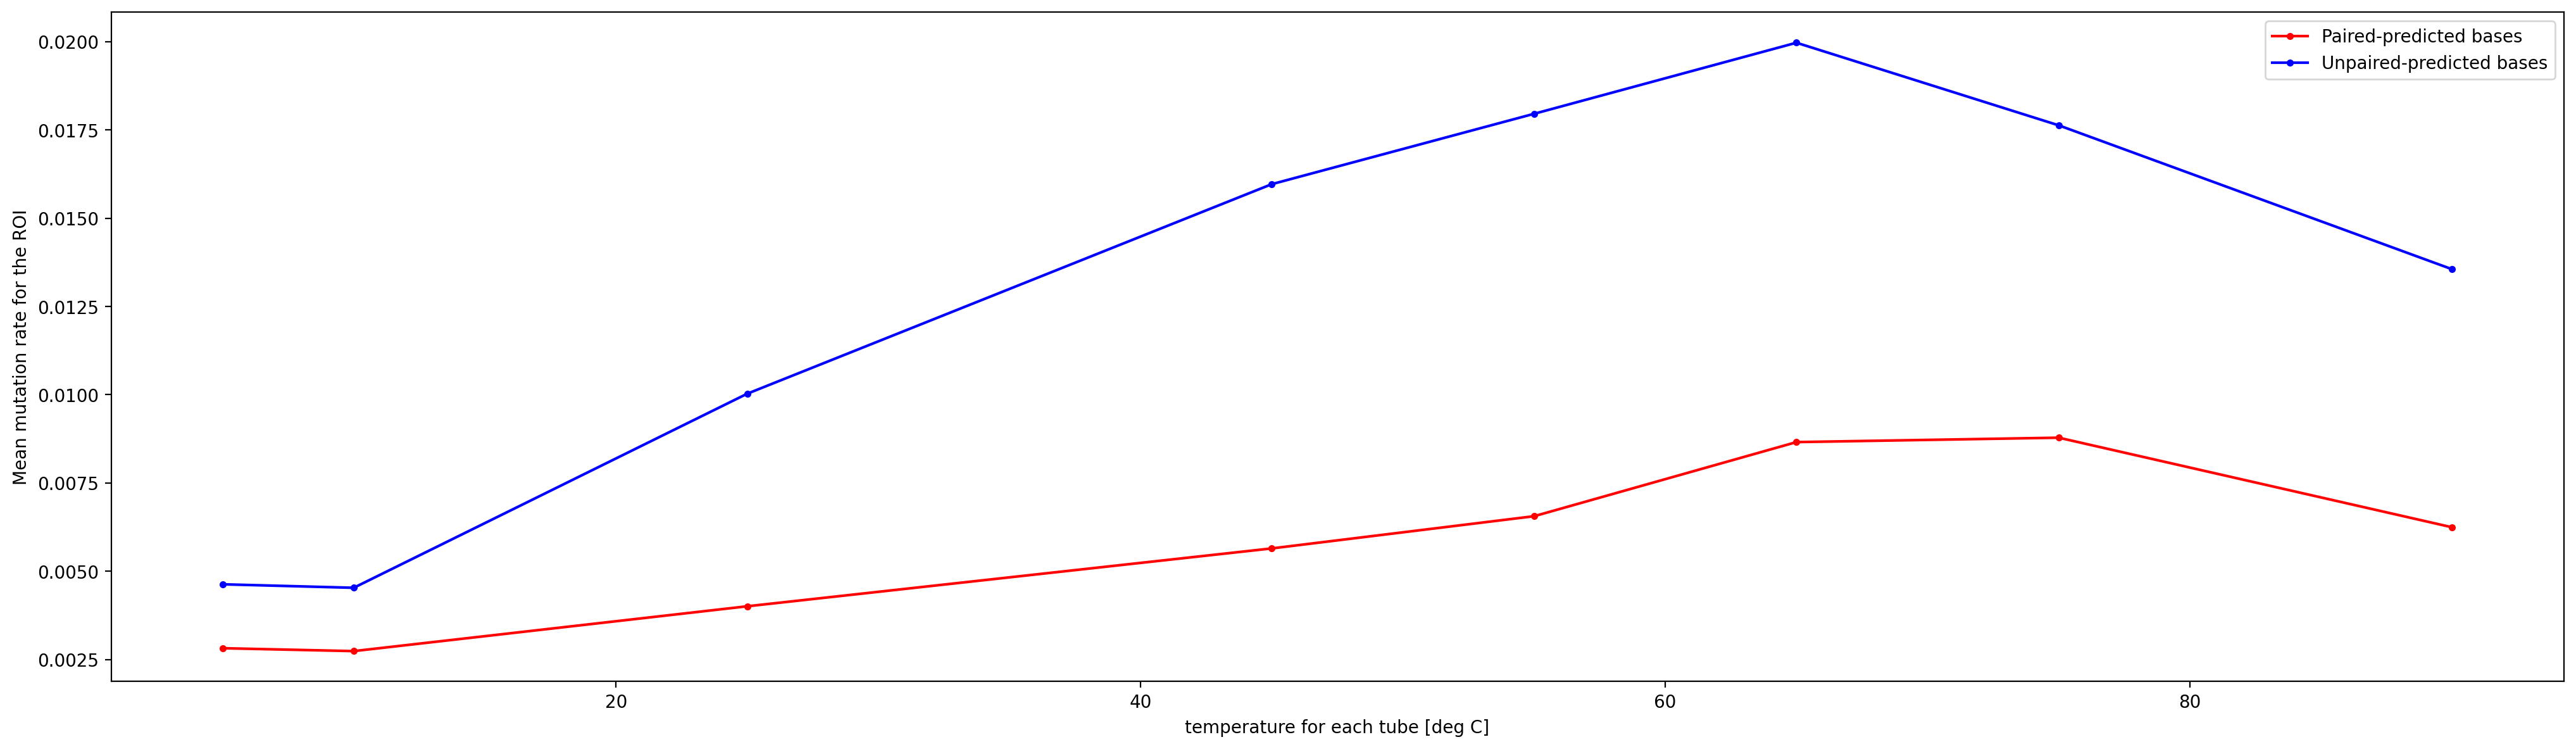

In [19]:
plot.mut_rate_along_study(df, samples, study)

### Save columns to a csv file

In [ ]:
utils.columns_to_csv(df=df,
                   samples=samples,
                   columns=['sample', 'construct','full_sequence','roi_sequence','mut_bases','info_bases'],
                   title=f"seq_and_reactivity_{study}",
                   path='data/figs/date/{study}')

### Save construct vs deltaG 

In [ ]:
utils.deltaG_vs_construct_to_csv(df=df,    
                                 title=f"deltaG_vs_construct.csv", 
                                 path = f"data/figs/date/{study}", 
                                 samples=samples)